<a href="https://colab.research.google.com/github/SammyXu129/DataScience-Customer_Churn_Model/blob/main/Churn_Possibility_Over_Time_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Problem
We will develop a statistic model that can predict the possibility of customers who will leave the company over time, using Survival Model

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [6]:
telco_df = pd.read_excel("/content/02 Churn-Dataset.xlsx")
telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.5,0,0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,Yes


In [11]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [12]:
telco_df['TotalCharges'] = pd.to_numeric(telco_df['TotalCharges'], errors='coerce')
telco_df['Churn'] = telco_df['Churn'].apply(lambda x : 1 if x == "Yes" else 0)
telco_df['SeniorCitizen'] = telco_df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
telco_df['SeniorCitizen'] = telco_df['SeniorCitizen'].astype('object')

In [13]:
telco_df.dropna(inplace = True)

In [14]:
telco_df.drop(['customerID'], axis = 1, inplace = True)

### Kaplan-Meier: single variable

In [15]:
#!pip3 install lifelines

In [16]:
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test

from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines import KaplanMeierFitter

In [17]:
kmf = KaplanMeierFitter()

T=telco_df['tenure']
C=telco_df['Churn'].astype(float)

kmf.fit(T,C)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7032 total observations, 5163 right-censored observations>

<Axes: title={'center': 'Kaplan-Meier Survival Curve: Population level'}, xlabel='timeline'>

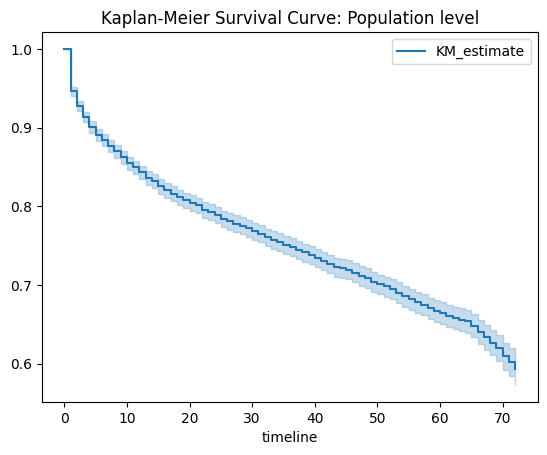

In [18]:
kmf.plot(title='Kaplan-Meier Survival Curve: Population level')

Interpretation: the probability of a customer surviving at least 0 month is 100%. Customer has around 60% probability will survive at least 70 months, given that they have survived 69 months. <p>
Confidence Interval: the wider interval, the smaller confidence. As the data reduces as the timeline moves, which is intuitively that there are less customers comparing the new ones.

In [19]:
# def plot_km(col):
#   ax = plt.subplot(111)
#   for r in telco_df[col].unique():
#     if r != 'No internet service' and r != 'No phone service':
#       ix = telco_df[col] == r
#       kmf.fit(T[ix], C[ix],label=r)
#       kmf.plot(ax=ax)

# def print_logrank(col):
#     mask = (telco_df[col] != 'No internet service') & (telco_df[col] != 'No phone service')
#     log_rank = pairwise_logrank_test(telco_df[mask]['tenure'], telco_df[mask][col], telco_df[mask]['Churn'])
#     return log_rank.summary

In [22]:
def plot_km(col):
  ax = plt.subplot(111)
  for r in telco_df[col].unique():
    ix = telco_df[col] == r
    kmf.fit(T[ix], C[ix],label=r)
    kmf.plot(ax=ax)


def print_logrank(col):
  log_rank = pairwise_logrank_test(telco_df['tenure'], telco_df[col], telco_df['Churn'])
  return log_rank.summary

When viewing Kaplan-Meier curves at the covariate-level, it's ideal to see some level of divergence between the groups as this indicates a difference that can be used for predictions. This is when survival curves are very close together, check whether they are statistically equivalent.<p>
This is the purpose of the log-rank test. The null hypothesis for the log-rank states that the groups are statistically equivalent. Although it's not useful for prediction to find out that the two groups are statistically equivalent, there are benefits from an inference standpoint. For example, suppose you have a new promotion that provides subscribers with free access to a streaming service. If you find out that those with the service are the same as those without the service, you may ask whether the return on providing free access is high enough to cover costs.


,,test_statistic,p,-log2(p)
Female,Male,0.525707,0.468417,1.094134


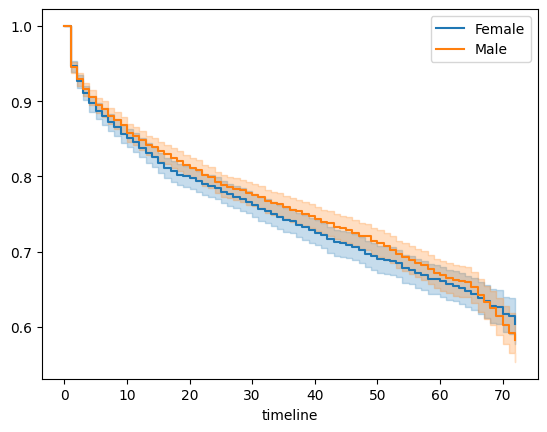

In [23]:
plot_km('gender')
print_logrank('gender')

,,test_statistic,p,-log2(p)
No,Yes,109.489693,1.267619e-25,82.706081


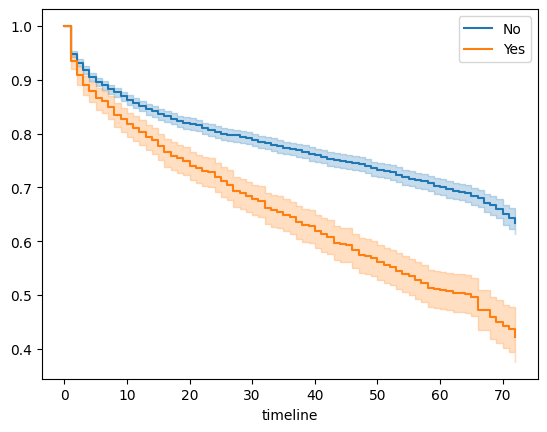

In [24]:
plot_km('SeniorCitizen')
print_logrank('SeniorCitizen')

,,test_statistic,p,-log2(p)
No,Yes,232.699042,1.537238e-52,172.11992


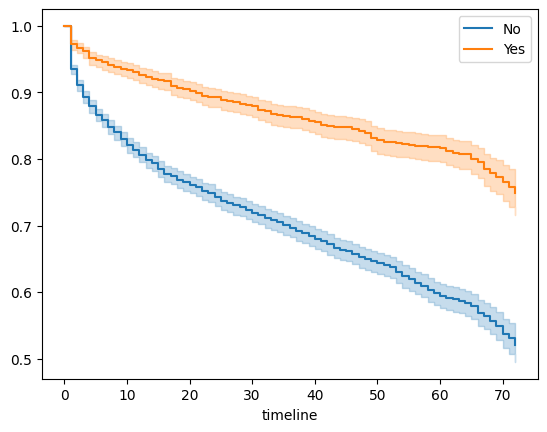

In [25]:
plot_km('Dependents')
print_logrank('Dependents')

,,test_statistic,p,-log2(p)
No,Yes,0.430819,0.511588,0.966947


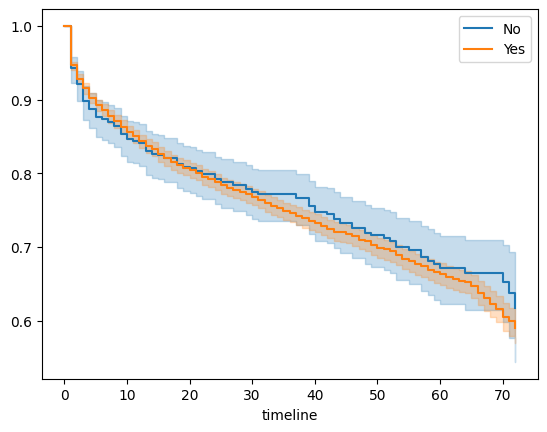

In [26]:
plot_km('PhoneService')
print_logrank('PhoneService')

test_statistic             p   -log2(p)
No               No phone service        3.370947  6.635560e-02   3.913638
                 Yes                    31.262663  2.253726e-08  25.403113
No phone service Yes                     1.561568  2.114358e-01   2.241709

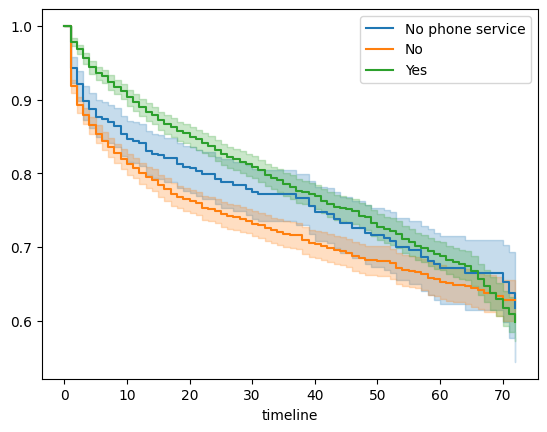

In [27]:
plot_km('MultipleLines')
print_logrank('MultipleLines')

test_statistic             p    -log2(p)
DSL         Fiber optic      227.174973  2.462919e-51  168.117964
            No                80.317890  3.187699e-19   61.444119
Fiber optic No               374.157435  2.328119e-83  274.500867

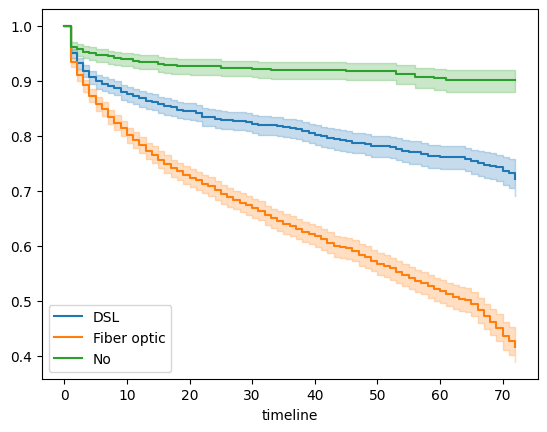

In [28]:
plot_km('InternetService')
print_logrank('InternetService')

test_statistic              p  \
No                  No internet service      485.975805  1.070135e-107   
                    Yes                      660.525069  1.148535e-145   
No internet service Yes                       11.060731   8.817539e-04   

                                           -log2(p)  
No                  No internet service  355.348514  
                    Yes                  481.479779  
No internet service Yes                   10.147336

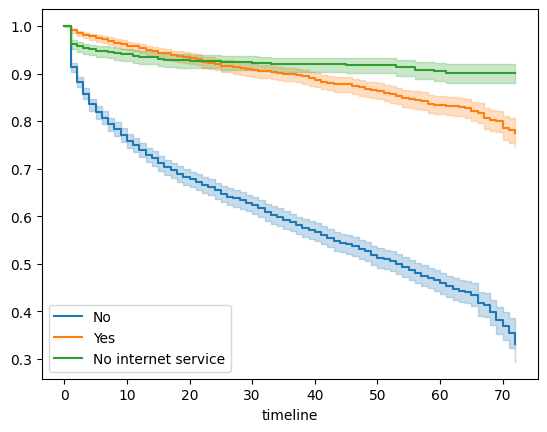

In [29]:
plot_km('OnlineSecurity')
print_logrank('OnlineSecurity')

test_statistic              p  \
No                  No internet service      472.481334  9.243051e-105   
                    Yes                      498.689704  1.832589e-110   
No internet service Yes                       52.778279   3.734080e-13   

                                           -log2(p)  
No                  No internet service  345.594081  
                    Yes                  364.538207  
No internet service Yes                   41.284312

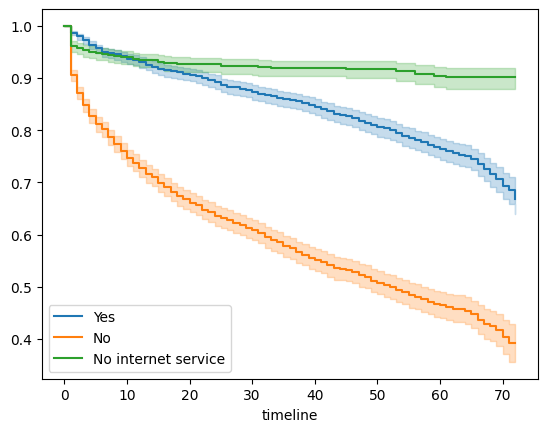

In [30]:
plot_km('OnlineBackup')
print_logrank('OnlineBackup')

test_statistic             p  \
No                  No internet service      336.023635  4.686697e-75   
                    Yes                      103.851367  2.180772e-24   
No internet service Yes                      148.309493  4.059550e-34   

                                           -log2(p)  
No                  No internet service  246.916036  
                    Yes                   78.601435  
No internet service Yes                  110.924235

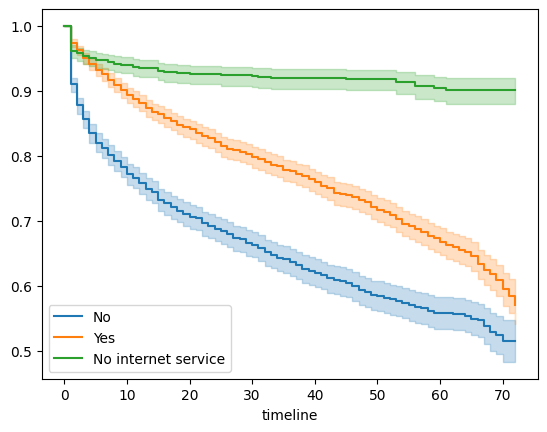

In [31]:
plot_km('StreamingTV')
print_logrank('StreamingTV')

test_statistic             p  \
No                  No internet service      340.855999  4.153842e-76   
                    Yes                      112.792732  2.395523e-26   
No internet service Yes                      146.131713  1.214918e-33   

                                           -log2(p)  
No                  No internet service  250.412089  
                    Yes                   85.109790  
No internet service Yes                  109.342769

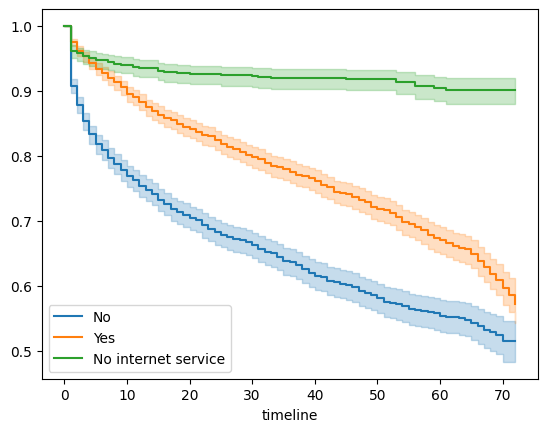

In [32]:
plot_km('StreamingMovies')
print_logrank('StreamingMovies')

test_statistic              p  \
No                  No internet service      461.819756  1.931446e-102   
                    Yes                      448.469744   1.552897e-99   
No internet service Yes                       61.343679   4.793276e-15   

                                           -log2(p)  
No                  No internet service  337.886984  
                    Yes                  328.235919  
No internet service Yes                   47.567909

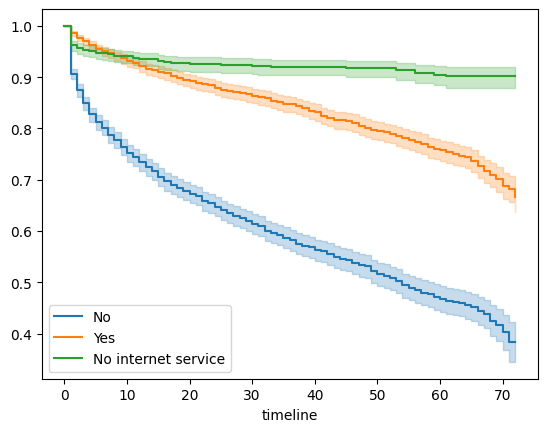

In [33]:
plot_km('DeviceProtection')
print_logrank('DeviceProtection')

test_statistic              p  \
No                  No internet service      482.287425  6.792153e-107   
                    Yes                      639.350003  4.627058e-141   
No internet service Yes                       13.894457   1.933679e-04   

                                           -log2(p)  
No                  No internet service  352.682437  
                    Yes                  466.181766  
No internet service Yes                   12.336364

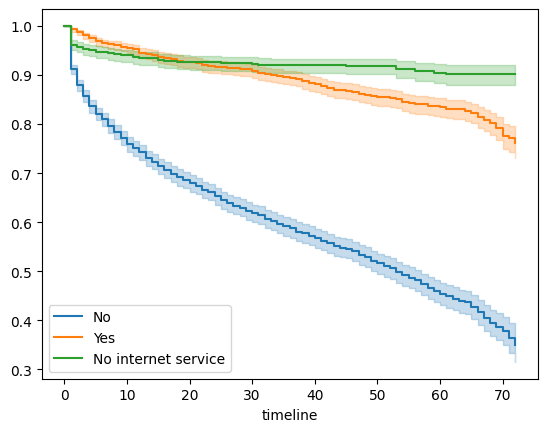

In [34]:
plot_km('TechSupport')
print_logrank('TechSupport')

,,test_statistic,p,-log2(p)
No,Yes,189.511486,4.064094e-43,140.819974


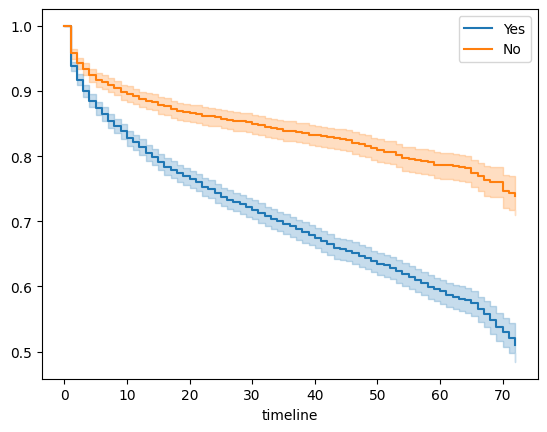

In [35]:
plot_km('PaperlessBilling')
print_logrank('PaperlessBilling')

test_statistic  \
Bank transfer (automatic) Credit card (automatic)        0.868295   
                          Electronic check             510.035059   
                          Mailed check                  51.071855   
Credit card (automatic)   Electronic check             539.740177   
                          Mailed check                  64.815174   
Electronic check          Mailed check                 152.455455   

                                                               p    -log2(p)  
Bank transfer (automatic) Credit card (automatic)   3.514278e-01    1.508700  
                          Electronic check         6.231417e-113  372.738314  
                          Mailed check              8.904593e-13   40.030516  
Credit card (automatic)   Electronic check         2.147615e-119  394.206708  
                          Mailed check              8.226320e-16   50.110602  
Electronic check          Mailed check              5.038297e-35  113.934547

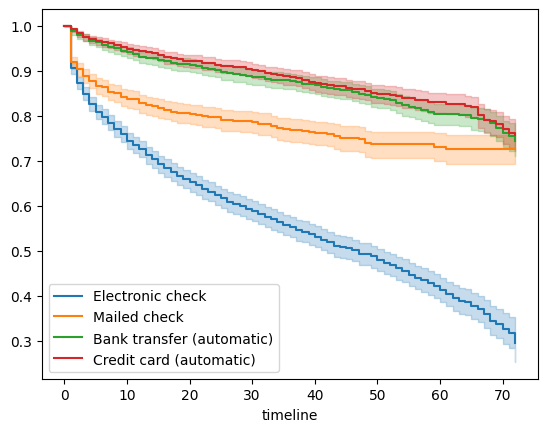

In [36]:
plot_km('PaymentMethod')
print_logrank('PaymentMethod')

test_statistic              p    -log2(p)
Month-to-month One year      926.064559  2.117327e-203  673.269159
               Two year     1550.510307   0.000000e+00         inf
One year       Two year      256.217767   1.145448e-57  189.153989

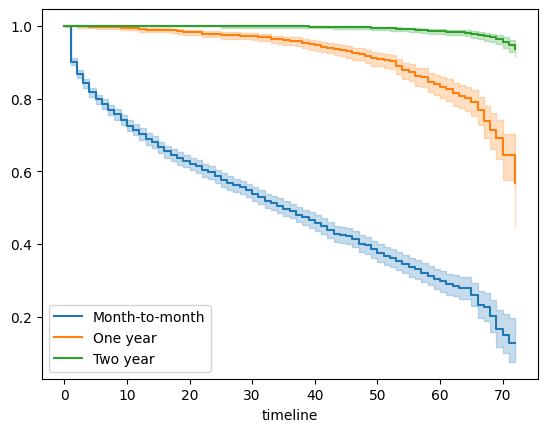

In [37]:
plot_km('Contract')
print_logrank('Contract')

### Cox Proportional Hazards: multi-variate analysis.

dropped the value that had a Kaplan-Meier survival probability curve most similar to the population.

In [38]:
cols = ["SeniorCitizen", "Dependents", "InternetService", "OnlineSecurity", "OnlineBackup", "StreamingTV", "StreamingMovies", "DeviceProtection", "TechSupport", "PaperlessBilling", "PaymentMethod", "Contract"]

encode_df = pd.get_dummies(telco_df,
               columns=cols,
               prefix=cols,
               drop_first=False)
encode_df.drop(['OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service','DeviceProtection_No internet service', 'TechSupport_No internet service'], axis = 1, inplace = True)
encode_df.head()

,gender,Partner,tenure,PhoneService,MultipleLines,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn,...,TechSupport_Yes,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_Month-to-month,Contract_One year,Contract_Two year
0,Female,Yes,1,No,No phone service,29.85,29.85,0,0,0,...,False,False,True,False,False,True,False,True,False,False
1,Male,No,34,Yes,No,56.95,1889.50,0,0,0,...,False,True,False,False,False,False,True,False,True,False
2,Male,No,2,Yes,No,53.85,108.15,0,0,1,...,False,False,True,False,False,False,True,True,False,False
3,Male,No,45,No,No phone service,42.30,1840.75,0,3,0,...,True,True,False,True,False,False,False,False,True,False
4,Female,No,2,Yes,No,70.70,151.65,0,0,1,...,False,False,True,False,False,True,False,True,False,False


In [39]:
survival_df = encode_df[['Churn', 'tenure', 'InternetService_DSL', 'OnlineBackup_Yes', 'Contract_Month-to-month']]

In [40]:
survival_df.loc[:,'Churn'] = survival_df.loc[:,'Churn'].astype('float')

In [41]:
cph = CoxPHFitter(alpha=0.05)
cph.fit(survival_df, 'tenure', 'Churn')

<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>

In [42]:
# from lifelines.utils import stepwise_selection
# tepwise_selection(cph, survival_df, 'tenure', 'Churn', covariates)

In [43]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7032
number of events observed = 1869
   partial log-likelihood = -14345.35
         time fit was run = 2024-07-18 07:01:03 UTC

---
                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                
InternetService_DSL     -0.21      0.81      0.05           -0.32           -0.11                0.73                0.90
OnlineBackup_Yes        -0.64      0.52      0.05           -0.75           -0.54                0.47                0.58
Contract_Month-to-month  2.98     19.66      0.08            2.82            3.14               16.80               23.00

                         cmp to      z      p  -log2(p)
covariate                                              
InternetService_DSL        0.00  -3.92 <0.005     13.49
OnlineBackup_Yes           0.00 -12.13 <0.005    110.09
Contract_Month-to-month    0.00  37.13 <0.005   1000.22
---
Concordance = 0.80
Partial AIC = 28696.70
log-likelihood ratio test = 2615.38 on 3 df
-log2(p) of ll-ratio test = inf

<Axes: xlabel='HR (95% CI)'>

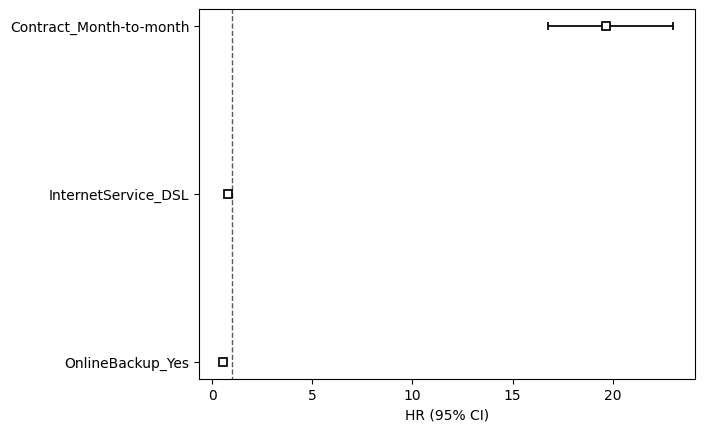

In [44]:
cph.plot(hazard_ratios=True)